In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
# %matplotlib inline
%config Completer.use_jedi = False

In [2]:
from datasets import InsectImgDataset
from utils import *
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

from torchvision import datasets
import torchvision.transforms as T
import torch.optim as optim
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

from category_encoders import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.utils import class_weight

setting = 'photobox'
if setting == 'photobox':
    ext = '.png'
elif setting == 'fuji':
    ext = '.jpg'
    
modelname = "densenet121"

Available workers: 16


# Creating train,val,test sets

## Removing outliers

In [3]:
df = pd.read_parquet(f"{SAVE_DIR}/df_preparation_{setting}.parquet")
# df = pd.merge(df,df_pre, on=['filename','platename','imgname','date','year','plate_idx','location','xtra'])
# df = df[df.knn_outlier==0]
# df = df[df.nb_contours>0]
# print(df.label.unique())

oe = OrdinalEncoder(cols=['label'],mapping=[{'col':'label', 'mapping':{'bl':0,'wswl':1,'sp':2,'t':3,'sw':4,'k':5,'m':6,'c':7,'v':8,'wmv':9,'wrl':10,'other':11}}])
df['txt_label'] = df['label']
df['label'] = oe.fit_transform(df.label)
df.label.value_counts()

8     5556
9     5285
7     4571
4     2532
3     2386
0     2332
6     1547
5     1082
10    1016
2      795
1      682
11     573
Name: label, dtype: int64

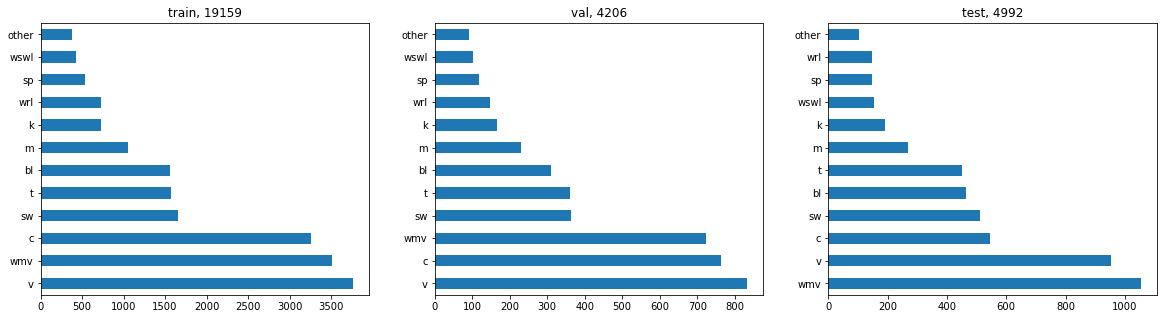

In [4]:
test_plates = train_test_split(df.platename.unique(), random_state=2022, test_size=0.2, shuffle=True)[1].tolist()
testseries = pd.Series(test_plates)
inds = testseries.apply(lambda x: 'wortel' in x)
inds = testseries[inds].sample(11).index.values
wortel_plates = testseries[inds].tolist()
test_plates = testseries[testseries.apply(lambda x: x.split('_')[1] != 'wortel')].tolist() + wortel_plates

df_trainval = df[~df.platename.isin(test_plates)]
df_test = df[df.platename.isin(test_plates)]

topclasses = df['label'].value_counts().head(12).index.tolist()

df = df[df['label'].isin(topclasses)]
df_trainval = df_trainval[df_trainval['label'].isin(topclasses)]
df_test = df_test[df_test['label'].isin(topclasses)]

class_weights = class_weight.compute_class_weight('balanced', 
                                                  classes=np.unique(df['label'].tolist()), 
                                                  y=df['label'].tolist())

class_weights = {np.unique(df['label'])[i]:class_weights[i] for i in range(len(class_weights))}
df['weights'] = df['label'].map(class_weights)

df_train, df_val = train_test_split(df_trainval, test_size=0.18, random_state=42, shuffle=True)


plt.figure(figsize=(20,5))
plt.subplot(1,3,1);df_train.txt_label.value_counts().plot(kind='barh');plt.title(f'train, {df_train.shape[0]}')
plt.subplot(1,3,2);df_val.txt_label.value_counts().plot(kind='barh');plt.title(f'val, {df_val.shape[0]}')
plt.subplot(1,3,3);df_test.txt_label.value_counts().plot(kind='barh');plt.title(f'test, {df_test.shape[0]}');

In [5]:
assert len(set(df_train.filename.tolist()).intersection(df_test.filename.tolist())) == 0
assert len(set(df_train.filename.tolist()).intersection(df_val.filename.tolist())) == 0

In [6]:
df_train.to_parquet(f"{SAVE_DIR}/df_train_{setting}.parquet")
df_val.to_parquet(f"{SAVE_DIR}/df_val_{setting}.parquet")
df_test.to_parquet(f"{SAVE_DIR}/df_test_{setting}.parquet")

In [7]:
df_train.label.value_counts()

8     3769
9     3508
7     3264
4     1657
3     1573
0     1558
6     1049
5      726
10     722
2      530
1      427
11     376
Name: label, dtype: int64

# Creating Pytorch Datasets and Dataloaders

# Cleaning with FastAI

In [10]:
path = Path('/mnt/EE7455C074558BE9/backups/data_backups/images/photobox_vs_fuji/photobox/')

In [11]:
from fastbook import *
from fastai.vision.all import *

In [14]:
fns = get_image_files(path)

In [15]:
failed = verify_images(fns)

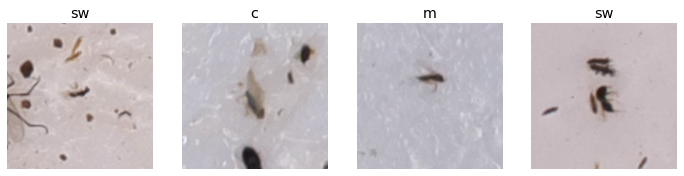

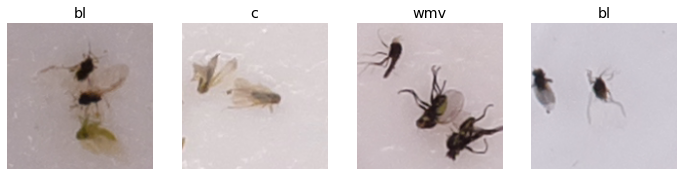

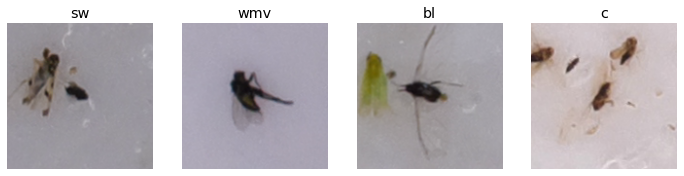

In [17]:
bears = DataBlock(
    # provide a tuple where we specify what types we want for the independent and dependent variables:
    blocks=(ImageBlock, CategoryBlock), # What kinds of data we are working with
    get_items=get_image_files, # How to get the list of items
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # How to create the validation set
    get_y=parent_label, # How to label these items, gets the name of the folder a file is in
    item_tfms=Resize(150)) # Transformation: picture resize

dls = bears.dataloaders(path) # the path where the images can be found
dls.train.show_batch(max_n=4, nrows=1) # check training set
dls.valid.show_batch(max_n=4, nrows=1) # check validation set
dls.show_batch(max_n=4, nrows=1) # check data


In [ ]:
learn = vision_learner(dls, xresnext50, metrics=error_rate)
learn.fine_tune(50)

epoch,train_loss,valid_loss,error_rate,time
0,2.082159,1.631913,0.503439,01:43


epoch,train_loss,valid_loss,error_rate,time
0,1.741853,1.410688,0.447716,03:42
1,1.618384,1.365862,0.436431,03:42


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
#hide_output
cleaner = ImageClassifierCleaner(learn)


ImageClassifierCleaner doesn't actually do the deleting or changing of labels for you; it just returns the indices of items to change.


In [ ]:
cleaner

In [ ]:
# ImageClassifierCleaner doesn't actually do the deleting or changing of labels for you; it just returns the indices of items to change.

In [ ]:
# # To delete (unlink) all images selected for deletion, we would run:

# for idx in cleaner.delete(): cleaner.fns[idx].unlink()

# # To move images for which we've selected a different category, we would run:

# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

